In [7]:
import torch, os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import cv2
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [8]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
#path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_pictures = "../data/BGR/Profilbilder/"
path_images = "images"
path_masks = "masks"

In [9]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Bodenart'])
print(len(df.index))
df#.head()

15207
15151


Point  HorizontID  Obergrenze  Untergrenze Horizontsymbol Bodenart  \
0         2.0         1.0         0.0         28.0          I; Ap      Sl2   
1         2.0         2.0        28.0         54.0           I; E      Sl2   
2         2.0         3.0        54.0         68.0         II; Bv      Sl2   
3         2.0         4.0        68.0         96.0   III; Bv-ilCv     fSms   
4         2.0         5.0        96.0        201.0      III; ilCv     mSfs   
...       ...         ...         ...          ...            ...      ...   
15201  6211.0         3.0        27.0         50.0      I; Bbh+Bs     fSms   
15202  6211.0         4.0        50.0         70.0      I; Bbs+Bs     fSms   
15203  6211.0         5.0        70.0        100.0      I; Go-Bbs     fSms   
15204  6211.0         6.0       100.0        130.0          I; Go     fSms   
15205  6211.0         7.0       130.0        155.0          I; Gr     fSms   

      Bodenfarbe  Steine Karbonat Humusgehaltsklasse Durchwurzelung  \
0      7.5YR 3/2     3.0       C0                 h3            Wf4   
1       10YR 3/3     3.0       C0                 h2            Wf3   
2      7.5YR 4/3    10.0       C0                 h1            Wf3   
3      7.5YR 6/4     1.0       C0                 h0            Wf2   
4       10YR 7/4     1.0       C0                 h0            NaN   
...          ...     ...      ...                ...            ...   
15201    5YR 3/2     1.0       C0                 h2            Wf3   
15202    5YR 4/3     1.0       C0                 h1            Wf2   
15203  7.5YR 5/4     1.0       C0                 h1            Wf6   
15204   2.5Y 6/4     1.0       C0                 h0            Wf4   
15205   2.5Y 5/4     1.0       C0                 h0            Wf2   

       Unnamed: 11 Bundesland  PointID  Unnamed: 14    profile  max_depth  
0              NaN         SH      2.0          NaN  BB_0541.0      100.0  
1              NaN         SH      3.0          NaN  BB_0600.0       90.0  
2              NaN         SH      4.0          NaN  BB_0601.0      100.0  
3              NaN         SH      5.0          NaN  BB_0659.0      100.0  
4              NaN         SH      6.0          NaN  BB_0660.0      100.0  
...            ...        ...      ...          ...        ...        ...  
15201          NaN        NaN      NaN          NaN        NaN        NaN  
15202          NaN        NaN      NaN          NaN        NaN        NaN  
15203          NaN        NaN      NaN          NaN        NaN        NaN  
15204          NaN        NaN      NaN          NaN        NaN        NaN  
15205          NaN        NaN      NaN          NaN        NaN        NaN  

[15151 rows x 17 columns]

In [10]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.head()

Horiz  Anzahl im Datensatz  \
0    Ap                 1762   
1    Bv                  626   
2  ilCv                  620   
3  elCv                  500   
4    Ah                  455   

  relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole  \
0                                                 Ap                                               
1                                                 Bv                                               
2                                                ilC                                               
3                                                elC                                               
4                                                 Ah                                               

  stark vereinfacht  
0                Ap  
1                Bv  
2                Cv  
3                Cv  
4                Ah

In [11]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Function to simplify a complex string based on the mapping
def simplify_string(complex_string, mapping_df):
    complex_symb = complex_string.split('; ')[1]
    # Find the matching simplified part in the mapping DataFrame
    simple_symb_series = mapping_df['stark vereinfacht'][mapping_df['Horiz'] == complex_symb]

    # Keep the complex symbol, when there is no simplified alternative
    if not simple_symb_series.empty:
        simple_symb = simple_symb_series.values[0]
    else:
        simple_symb = complex_symb

    return simple_symb

# Apply the simplification function to each row of the 'Horizontsymbol' column
df['Horizontsymbol_einfach'] = df['Horizontsymbol'].apply(lambda x: simplify_string(x, df_simple))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_einfach')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

Point  HorizontID  Obergrenze  Untergrenze Horizontsymbol  \
0         2.0         1.0         0.0         28.0          I; Ap   
1         2.0         2.0        28.0         54.0           I; E   
2         2.0         3.0        54.0         68.0         II; Bv   
3         2.0         4.0        68.0         96.0   III; Bv-ilCv   
4         2.0         5.0        96.0        201.0      III; ilCv   
...       ...         ...         ...          ...            ...   
15201  6211.0         3.0        27.0         50.0      I; Bbh+Bs   
15202  6211.0         4.0        50.0         70.0      I; Bbs+Bs   
15203  6211.0         5.0        70.0        100.0      I; Go-Bbs   
15204  6211.0         6.0       100.0        130.0          I; Go   
15205  6211.0         7.0       130.0        155.0          I; Gr   

      Horizontsymbol_einfach Bodenart Bodenfarbe  Steine Karbonat  \
0                         Ap      Sl2  7.5YR 3/2     3.0       C0   
1                          E      Sl2   10YR 3/3     3.0       C0   
2                         Bv      Sl2  7.5YR 4/3    10.0       C0   
3                      Bv-Cv     fSms  7.5YR 6/4     1.0       C0   
4                         Cv     mSfs   10YR 7/4     1.0       C0   
...                      ...      ...        ...     ...      ...   
15201                 Bbh+Bs     fSms    5YR 3/2     1.0       C0   
15202                 Bbs+Bs     fSms    5YR 4/3     1.0       C0   
15203                 Go-Bbs     fSms  7.5YR 5/4     1.0       C0   
15204                     Go     fSms   2.5Y 6/4     1.0       C0   
15205                     Gr     fSms   2.5Y 5/4     1.0       C0   

      Humusgehaltsklasse Durchwurzelung  Unnamed: 11 Bundesland  PointID  \
0                     h3            Wf4          NaN         SH      2.0   
1                     h2            Wf3          NaN         SH      3.0   
2                     h1            Wf3          NaN         SH      4.0   
3                     h0            Wf2          NaN         SH      5.0   
4                     h0            NaN          NaN         SH      6.0   
...                  ...            ...          ...        ...      ...   
15201                 h2            Wf3          NaN        NaN      NaN   
15202                 h1            Wf2          NaN        NaN      NaN   
15203                 h1            Wf6          NaN        NaN      NaN   
15204                 h0            Wf4          NaN        NaN      NaN   
15205                 h0            Wf2          NaN        NaN      NaN   

       Unnamed: 14    profile  max_depth  
0              NaN  BB_0541.0      100.0  
1              NaN  BB_0600.0       90.0  
2              NaN  BB_0601.0      100.0  
3              NaN  BB_0659.0      100.0  
4              NaN  BB_0660.0      100.0  
...            ...        ...        ...  
15201          NaN        NaN        NaN  
15202          NaN        NaN        NaN  
15203          NaN        NaN        NaN  
15204          NaN        NaN        NaN  
15205          NaN        NaN        NaN  

[15151 rows x 18 columns]

In [12]:
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float)
img_files.head()

file   Point
0  BB_0896_Y_1.JPG   896.0
1  BB_0903_Y_1.JPG   903.0
2  BW_4930_Y_1.JPG  4930.0
3  BW_5183_Y_1.JPG  5183.0
4  BW_5462_Y_1.JPG  5462.0

In [13]:
df = pd.merge(df, img_files, how='inner', on='Point')
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
df.head()

Point  HorizontID  Obergrenze  Untergrenze Horizontsymbol  \
0    2.0         1.0         0.0         28.0          I; Ap   
1    2.0         2.0        28.0         54.0           I; E   
2    2.0         3.0        54.0         68.0         II; Bv   
3    2.0         4.0        68.0         96.0   III; Bv-ilCv   
4    2.0         5.0        96.0        201.0      III; ilCv   

  Horizontsymbol_einfach Bodenart Bodenfarbe  Steine Karbonat  \
0                     Ap      Sl2  7.5YR 3/2     3.0       C0   
1                      E      Sl2   10YR 3/3     3.0       C0   
2                     Bv      Sl2  7.5YR 4/3    10.0       C0   
3                  Bv-Cv     fSms  7.5YR 6/4     1.0       C0   
4                     Cv     mSfs   10YR 7/4     1.0       C0   

  Humusgehaltsklasse Durchwurzelung  Unnamed: 11 Bundesland  PointID  \
0                 h3            Wf4          NaN         SH      2.0   
1                 h2            Wf3          NaN         SH      3.0   
2                 h1            Wf3          NaN         SH      4.0   
3                 h0            Wf2          NaN         SH      5.0   
4                 h0            NaN          NaN         SH      6.0   

   Unnamed: 14    profile  max_depth                                      file  
0          NaN  BB_0541.0      100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG  
1          NaN  BB_0600.0       90.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG  
2          NaN  BB_0601.0      100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG  
3          NaN  BB_0659.0      100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG  
4          NaN  BB_0660.0      100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG

In [14]:
# Profile images only show horizons up to ~1 meter depth
filtered_df = df[df['Obergrenze'] <= 100]

# Number of horizons down to 1 meter will be used as k in KMeans per image
horizon_counts = filtered_df.groupby('file').size()
horizon_counts

file
../data/BGR/Profilbilder/BB_0541_Y_1.JPG    4
../data/BGR/Profilbilder/BB_0600_Y_1.JPG    6
../data/BGR/Profilbilder/BB_0601_Y_1.JPG    4
../data/BGR/Profilbilder/BB_0659_Y_1.JPG    4
../data/BGR/Profilbilder/BB_0660_Y_1.JPG    6
                                           ..
../data/BGR/Profilbilder/TH_3489_Y_1.JPG    4
../data/BGR/Profilbilder/TH_3494_Y_1.JPG    3
../data/BGR/Profilbilder/TH_3496_Y_1.JPG    5
../data/BGR/Profilbilder/TH_3545_Y_1.JPG    4
../data/BGR/Profilbilder/TH_3596_Y_1.JPG    3
Length: 3385, dtype: int64

In [15]:
max(horizon_counts)

8

In [16]:
# Dictionary with lower bounds of the horizons per file
lower_bounds = {}

for index, row in filtered_df.iterrows():
    file_name = row['file']
    untergrenze = row['Untergrenze']

    if file_name not in lower_bounds:
        lower_bounds[file_name] = []

    lower_bounds[file_name].append(untergrenze)

In [17]:
df_k = pd.read_csv(path_csv_annotator_ids)
df_k = df_k.rename({'PointID':'Point'},axis=1)
df_k.head()

Point Aufnehmer
0      2    Kart8 
1      3    Kart8 
2      4    Kart10
3      5    Kart8 
4      6    Kart8

In [18]:
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
df_loc.head()

Point Bundesland  Probenahme_Monat  Probenahme_Jahr       xcoord  \
0     2         SH                11             2015  462216.1283   
1     3         SH                 6             2016  480546.9384   
2     4         SH                 8             2018  484922.3074   
3     5         SH                10             2015  497355.9905   
4     6         SH                10             2015  505020.3377   

        ycoord Bodenklimaraum_Name Landnutzung BZE_Moor Hauptbodentyp  \
0  6079359.775       Marsch - Nord           A        0            YE   
1  6079739.216       Marsch - Nord           G        0            MD   
2  6080011.471       Marsch - Nord           A        0            MK   
3  6079646.589       Marsch - Nord           G        0            RQ   
4   6080401.37        Geest - Nord           G        0            YU   

  BodenVarTypSub GrundwaStufe GrundwaStand  Moormaechtigkeit  \
0          YE/BB            0         >200               0.0   
1            MDn         GWS4          135               0.0   
2            MKn         GWS4          105               0.0   
3     p2RQ/GG-PP         GWS4          180               0.0   
4        aGGe-YU         GWS4          140               0.0   

   Torfmaechtigkeit Neigung Exposition Woelbung Reliefformtyp LageImRelief  \
0               0.0      N0        NaN       GG             V            Z   
1               0.0      N0        NaN       GG           TSF            Z   
2               0.0      N1         NE       GG            TH            Z   
3               0.0    N0.2         SS       GG           KSF            K   
4               0.0      N0        NaN       GG           TSF            Z   

   KV_0_30  KV_30_100  
0    81.89      54.19  
1    71.62      59.74  
2    65.60     120.40  
3    88.82     220.87  
4    62.97      84.35

In [19]:
df = pd.merge(df, df_k, how='inner', on='Point')

In [20]:
df_loc['Point'] = pd.to_numeric(df['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')

In [21]:
df[df['ycoord']=='N0'] # invalid ycoord?

Point  HorizontID  Obergrenze  Untergrenze Horizontsymbol  \
709    24.0         1.0         0.0         32.0          I; Ap   
714    24.0         2.0        32.0         50.0       I; Al-Sw   
719    24.0         3.0        50.0         73.0      II; Bt-Sd   
724    24.0         4.0        73.0        152.0         II; Sd   
729    24.0         5.0       152.0        201.0       III; lCv   
4105  172.0         1.0         0.0         33.0          I; Ap   
4109  172.0         2.0        33.0         53.0          I; Sw   
4113  172.0         3.0        53.0        120.0         I; Swd   
4117  172.0         4.0       120.0        201.0        II; eSd   

     Horizontsymbol_einfach Bodenart Bodenfarbe  Steine Karbonat  \
709                      Ap      Sl4   10YR 3/3     5.0       C0   
714                   Al-Sw      Ls4   2.5Y 5/4     5.0       C0   
719                   Bt-Sd      Ls3   10YR 4/4     4.0       C0   
724                      Sd      Ls3   2.5Y 5/4     4.0       C0   
729                      Cv      Ls3   2.5Y 6/3     3.0     C3.4   
4105                     Ap      Sl2   10YR 3/2     3.0       C0   
4109                     Sw      Sl2   10YR 5/4     3.0       C0   
4113                     Sd      Sl3   2.5Y 5/4     3.0       C0   
4117                     Sd      Sl4   2.5Y 5/4     3.0     C3.3   

     Humusgehaltsklasse Durchwurzelung  Unnamed: 11 Bundesland_x  PointID  \
709                  h3            Wf3          NaN           SH    155.0   
714                  h1            Wf2          NaN           SH    156.0   
719                  h0            Wf1          NaN           SH    158.0   
724                  h0            NaN          NaN           SH    160.0   
729                  h0            NaN          NaN           SH    161.0   
4105                 h3            Wf4          NaN           ST   1183.0   
4109                 h0            Wf2          NaN           ST   1185.0   
4113                 h0            NaN          NaN           BB   1186.0   
4117                 h0            NaN          NaN           BB   1187.0   

      Unnamed: 14    profile  max_depth  \
709           NaN  BB_1319.0      100.0   
714           NaN  BB_1327.0       80.0   
719           NaN  BB_1329.0      100.0   
724           NaN  BB_1331.0      100.0   
729           NaN  BB_1333.0       90.0   
4105          NaN  BY_4419.0      100.0   
4109          NaN  BY_4425.0      100.0   
4113          NaN  BY_4427.0      100.0   
4117          NaN  BY_4428.0       70.0   

                                          file Aufnehmer Bundesland_y  \
709   ../data/BGR/Profilbilder/SH_0024_Y_1.JPG    Kart8          GWS3   
714   ../data/BGR/Profilbilder/SH_0024_Y_1.JPG    Kart8          GWS3   
719   ../data/BGR/Profilbilder/SH_0024_Y_1.JPG    Kart8          GWS3   
724   ../data/BGR/Profilbilder/SH_0024_Y_1.JPG    Kart8          GWS3   
729   ../data/BGR/Profilbilder/SH_0024_Y_1.JPG    Kart8          GWS3   
4105  ../data/BGR/Profilbilder/MV_0172_Y_1.JPG    Kart8          GWS4   
4109  ../data/BGR/Profilbilder/MV_0172_Y_1.JPG    Kart8          GWS4   
4113  ../data/BGR/Profilbilder/MV_0172_Y_1.JPG    Kart8          GWS4   
4117  ../data/BGR/Profilbilder/MV_0172_Y_1.JPG    Kart8          GWS4   

      Probenahme_Monat  Probenahme_Jahr  xcoord ycoord Bodenklimaraum_Name  \
709                120                0     0.0     N0                 NaN   
714                120                0     0.0     N0                 NaN   
719                120                0     0.0     N0                 NaN   
724                120                0     0.0     N0                 NaN   
729                120                0     0.0     N0                 NaN   
4105               110               42    24.0     N0                 NaN   
4109               110               42    24.0     N0                 NaN   
4113               110               42    24.0     N0                 NaN   
4117               

In [22]:
keep_columns = ['Point',
                'HorizontID',
                'Obergrenze',
                'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_einfach',
                'Bodenart',
                'Bodenfarbe',
                'Steine',
                'Karbonat',
                'Humusgehaltsklasse',
                'Durchwurzelung',
                'max_depth',
                'file',
                'Aufnehmer',
                'Probenahme_Monat',
                'Probenahme_Jahr',
                'xcoord',
                'ycoord',
                'Bodenklimaraum_Name',
                'Landnutzung',
                'BZE_Moor',
                'Hauptbodentyp',
                'BodenVarTypSub',
                'GrundwaStufe',
                'GrundwaStand',
                'Moormaechtigkeit',
                'Torfmaechtigkeit',
                'Neigung',
                'Exposition',
                'Woelbung',
                'Reliefformtyp',
                'LageImRelief',
                'KV_0_30',
                'KV_30_100']

df = df[keep_columns]

df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
#df['xcoord'] = df['xcoord'].str.replace(',','.').astype(float)
#df['ycoord'] = df['ycoord'].str.replace(',','.').astype(float)
df['ycoord'] = df['ycoord'].str.replace('N0','0').astype(float)
#df['KV_0_30'] = df['KV_0_30'].str.replace(',','.').astype(float)
#df['KV_30_100'] = df['KV_30_100'].str.replace(',','.').astype(float)

df

Point  HorizontID  Obergrenze  Untergrenze Horizontsymbol_einfach  \
0         2.0         1.0         0.0         28.0                     Ap   
1         2.0         1.0         0.0         28.0                     Ap   
2         2.0         1.0         0.0         28.0                     Ap   
3         2.0         1.0         0.0         28.0                     Ap   
4         2.0         1.0         0.0         28.0                     Ap   
...       ...         ...         ...          ...                    ...   
17901  1055.0         6.0       100.0        180.0                     Cv   
17902  1055.0         6.0       100.0        180.0                     Cv   
17903  1055.0         6.0       100.0        180.0                     Cv   
17904  1055.0         6.0       100.0        180.0                     Cv   
17905  1055.0         6.0       100.0        180.0                     Cv   

      Bodenart Bodenfarbe  Steine Karbonat Humusgehaltsklasse Durchwurzelung  \
0          Sl2  7.5YR 3/2     3.0       C0                 h3            Wf4   
1          Sl2  7.5YR 3/2     3.0       C0                 h3            Wf4   
2          Sl2  7.5YR 3/2     3.0       C0                 h3            Wf4   
3          Sl2  7.5YR 3/2     3.0       C0                 h3            Wf4   
4          Sl2  7.5YR 3/2     3.0       C0                 h3            Wf4   
...        ...        ...     ...      ...                ...            ...   
17901       mS        NaN     NaN       C0                 h0            NaN   
17902       mS        NaN     NaN       C0                 h0            NaN   
17903       mS        NaN     NaN       C0                 h0            NaN   
17904       mS        NaN     NaN       C0                 h0            NaN   
17905       mS        NaN     NaN       C0                 h0            NaN   

       max_depth                                      file Aufnehmer  \
0          100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG    Kart8    
1          100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG    Kart8    
2          100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG    Kart8    
3          100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG    Kart8    
4          100.0  ../data/BGR/Profilbilder/SH_0002_Y_1.JPG    Kart8    
...          ...                                       ...       ...   
17901        NaN  ../data/BGR/Profilbilder/NI_1055_Y_1.JPG    Kart9    
17902        NaN  ../data/BGR/Profilbilder/NI_1055_Y_1.JPG    Kart9    
17903        NaN  ../data/BGR/Profilbilder/NI_1055_Y_1.JPG    Kart9    
17904        NaN  ../data/BGR/Profilbilder/NI_1055_Y_1.JPG    Kart9    
17905        NaN  ../data/BGR/Profilbilder/NI_1055_Y_1.JPG    Kart9    

       Probenahme_Monat  Probenahme_Jahr       xcoord       ycoord  \
0                    11             2015  462216.1283  6079359.775   
1                     6             2016  480546.9384  6079739.216   
2                     8             2018  484922.3074  6080011.471   
3                    10             2015  497355.9905  6079646.589   
4                    10             2015  505020.3377  6080401.370   
...                 ...              ...          ...          ...   
17901                 3             2012  384409.7401  5456592.806   
17902                 2             2012  437827.5634  5454050.546   
17903                10             2011  448236.4426  5454486.160   
17904                11             2011  450265.8395  5448367.068   
17905                 6             2012  522076.9633  5930456.114   

                            Bodenklimaraum_Name Landnutzung BZE_Moor  \
0                                 Marsch - Nord           A        0   
1                                 Marsch - Nord           G        0   
2                                 Marsch - Nord           A        0   
3                                 Marsch - Nord           G        0   
4                                  Geest - Nord         

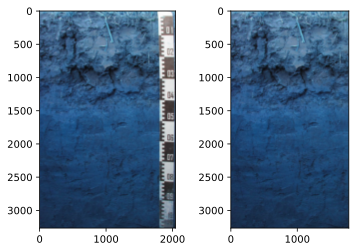

In [45]:
def remove_ruler(image):

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 50, 200, apertureSize=3)

    # Detect lines using Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=150, maxLineGap=10)

    # Filter lines to identify ruler lines
    ruler_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < 10:  # Filter for nearly vertical lines
            ruler_lines.append(line)

    # Find bounding box of ruler region
    x_min = min(line[0][0] for line in ruler_lines)
    x_max = max(line[0][2] for line in ruler_lines)

    # Crop the image, excluding the ruler region
    cropped_image = image[:, :x_min] if x_min > image.shape[1] // 2 else image[:, x_max:]

    return cropped_image

img_orig = cv2.imread(path_pictures + image_dataset[20])
img_no_ruler = remove_ruler(img_orig)

plt.subplot(121)
plt.imshow(img_orig)
plt.subplot(122)
plt.imshow(img_no_ruler);

In [17]:
def center_crop(img_file, x_len, y_len):
    img = cv2.imread(img_file) #Image.open(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV uses BGR format

    center_x, center_y = int(img.shape[0] / 2), int(img.shape[1] / 2)

    left  = center_x - x_len
    right = center_x + x_len
    upper = center_y - y_len
    lower = center_y + y_len

    return img[upper:lower, left:right]

In [18]:
x_len, y_len = 280, 600
max_imgs = 10
plt.figure(figsize=(3*max_imgs, 15))

for i, (file, k) in enumerate(horizon_counts.items()):
    if i == max_imgs: break
    img = center_crop(file, x_len, y_len)

    img = img_as_float(img[::2, ::2])

    segments_slic = slic(img, n_segments= 5*k, compactness=10.,
                         spacing=(2,1), sigma=10, start_label=1, convert2lab=True)

    plt.subplot(1, max_imgs, i+1)
    plt.imshow(mark_boundaries(img, segments_slic))
    plt.xlabel(f'{len(np.unique(segments_slic))} segments, k={k}', fontsize=20)
    plt.xticks([], []); plt.yticks([], [])

plt.tight_layout()
plt.show()

In [69]:
def create_rect_mask(height, width, untergrenze_list):

    mask = np.zeros((height, width), dtype=int)
    current_region = 0

    # Some horizons have the lowest cutoff below -1 meter in the images
    # Add an extra border at 100 to avoid errors when drawing the rectangles
    if np.max(untergrenze_list) < 100.:
        untergrenze_list.append(100.)

    for i in range(height):
        if i > untergrenze_list[current_region] * height/100.:
            current_region += 1

        mask[i, :] = current_region+1

    return mask

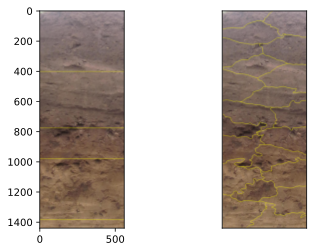

In [73]:
x_len, y_len = 280, 720
for file_name, untergrenze_list in lower_bounds.items():
    img = center_crop(file_name, x_len, y_len)
    img_float = img_as_float(img)#[::2, ::2])
    height, width, _ = img_float.shape

    segments_slic = slic(img_float, n_segments= 5*k, compactness=10.,
                         spacing=(2,1), sigma=10, start_label=1, convert2lab=True)
    rect_mask = create_rect_mask(height, width, untergrenze_list)

    plt.subplot(121)
    plt.imshow(mark_boundaries(img_float, rect_mask))
    plt.subplot(122)
    plt.imshow(mark_boundaries(img_float, segments_slic))
    plt.xticks([], []); plt.yticks([], [])
    break

In [ ]:
def group_patches(untergrenze_list, seg_mask):

    untergrenze_pix_y = np.asarray(untergrenze_list) * height/100

    combi_mask = np.zeros_like(seg_mask)
    for patch_id in np.unique(seg_mask):

        # Get indexes of patch pixels
        patch_inds = np.where(seg_mask == patch_id) # tuple of y and x coords

        # Check whether the patch is intersecting any of the rectangle borders
        # It would mean that a boundary lies between the minimal and maximal row index of that patch
        intersecting_border = [ u for u in untergrenze_pix_y if np.min(patch_inds[0]) <= u <= np.max(patch_inds[0]) ]
        if not intersecting_border:
            # Get the index of the first rectangle border that is below the lowest row index of the patch
            next_lower_border = np.min([u for u in untergrenze_pix_y if u > np.max(patch_inds[0])])
            combi_mask[patch_inds] = np.where(untergrenze_pix_y == next_lower_border)[0]

        # Check whether the patch has more pixels in the rectangle above or below the border
        # Count how many row indexes are above the y coord of the intersecting border and below
        # Assign the patch the label of the rectangle intersecting the patch the most
        else:
            num_pix_above = np.count_nonzero(patch_inds[0] <= intersecting_border[0])
            num_pix_below = np.count_nonzero(patch_inds[0] > intersecting_border[0])

            if num_pix_above > num_pix_below:
                combi_mask[patch_inds] = np.where(untergrenze_pix_y == intersecting_border[0])[0]
            else:
                combi_mask[patch_inds] = np.where(untergrenze_pix_y == intersecting_border[0])[0] + 1

    return combi_mask

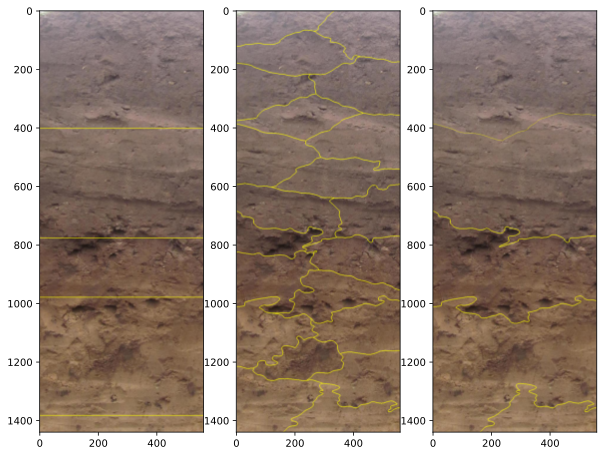

In [74]:
plt.figure(figsize=(10,8))
plt.subplot(131)
plt.imshow(mark_boundaries(img_float, rect_mask))
plt.subplot(132)
plt.imshow(mark_boundaries(img_float, segments_slic))
plt.subplot(133)
combi_mask = group_patches(untergrenze_list, segments_slic)
plt.imshow(mark_boundaries(img_float, combi_mask))
plt.show()

In [75]:
max_imgs = 6

plt.figure(figsize=(3*max_imgs, 15))
for i, (file_name, untergrenze_list) in enumerate(lower_bounds.items()):
    if i == max_imgs: break
    cropped_img = center_crop(file_name, x_len, y_len)

    img_float = img_as_float(cropped_img)#[::2, ::2])
    height, width, _ = img_float.shape

    segments_slic = slic(img_float, n_segments= 5*k, compactness=10.,
                         spacing=(2,1), sigma=10, start_label=1, convert2lab=True)
    rect_mask = create_rect_mask(height, width, untergrenze_list)
    combi_mask = group_patches(untergrenze_list, segments_slic)

    plt.subplot(3, max_imgs, 3*i+1)
    plt.imshow(mark_boundaries(img_float, rect_mask, color=(1,0,0)))
    plt.xticks([], []); plt.yticks([], [])

    plt.subplot(3, max_imgs, 3*i+2)
    plt.imshow(mark_boundaries(img_float, segments_slic, color=(1,0,0)))
    plt.xticks([], []); plt.yticks([], [])

    plt.subplot(3, max_imgs, 3*i+3)
    plt.imshow(mark_boundaries(img_float, combi_mask, color=(1,0,0)))
    plt.xticks([], []); plt.yticks([], [])
plt.tight_layout()
plt.show()